This notebook will now have 

1. Regression of Behavior + GCamp 

**Regression packages**

statsmodel 

edward

PYRO (noah goodman) 






In [1]:
import numpy as np 
import pandas as pd
import pystan
import stan_utility
import scipy
import _pickle as cPickle


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec


import seaborn as sns
import pandas as pd
import os

# to render plots with white background
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.75)



In [2]:
%load_ext rpy2.ipython
%R library(lme4)
%R library(parallel)
%R library(lmerTest)
%R library(MuMIn, quiet = True)

/Users/sasha/anaconda/envs/biomath/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Matrix

  warnings.warn(x, RRuntimeWarning)
/Users/sasha/anaconda/envs/biomath/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘lmerTest’


  warnings.warn(x, RRuntimeWarning)
/Users/sasha/anaconda/envs/biomath/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘package:lme4’:

    lmer


  warnings.warn(x, RRuntimeWarning)
/Users/sasha/anaconda/envs/biomath/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘package:stats’:

    step


  warnings.warn(x, RRuntimeWarning)


array(['MuMIn', 'lmerTest', 'parallel', 'lme4', 'Matrix', 'tools', 'stats',
       'graphics', 'grDevices', 'utils', 'datasets', 'methods', 'base'],
      dtype='<U9')

In [3]:
%load_ext jupyternotify

%autonotify -a 30

<IPython.core.display.Javascript object>

In [4]:
%%R
f_lmer_mc = function(data, calls, mc.cores) {
    require(parallel)
    if (is.data.frame(data)) 
        data = replicate(length(calls), data, simplify = F)
    for (i in 1:length(data)) attr(data[[i]], "cll") = calls[i]
    m.list = mclapply(data, function(i) eval(parse(text = attr(i, "cll"))), 
        mc.cores = mc.cores)
    return(m.list)
}

In [5]:
%%time
# These are the loaded dataframes that are calculated below

df_corr_all = pd.read_csv("data/int_pc_qvals_gcamp.csv", index_col = 0) # .dropna(subset=['Q_dir_diff'])


df_trials = pd.read_csv("data/int_pc_qvals.csv", index_col = 0)


# update the gcamp values from strings --> arrays of floats 
df_src = df_corr_all

df_src['g_np'] = df_src['g_np'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))
df_src['g_lp'] = df_src['g_lp'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))
df_src['g_choice'] = df_src['g_choice'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))
df_src['g_reward'] = df_src['g_reward'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))



CPU times: user 3.62 s, sys: 223 ms, total: 3.84 s
Wall time: 4.1 s


In [6]:
# some additional constants 

# for gcamp (dt = dt of gcamp recordings)
dt = 15
LEN_BEFORE = dt
LEN_AFTER = dt * 2
GCAMP_RANGE = np.arange(-1, 2, 1/dt)

# for trials in general 

NS = len(np.unique(df_trials['MouseID']))

NT = max(df_trials.groupby('MouseID').count()['Trial'])
NT_all = df_trials.groupby('MouseID').count()['Trial']

c_str = np.empty([NS, NT], 'str')
r = np.empty([NS, NT], int)
r.fill(-1) # init with nan to ensure that shorter trials dont' get false data 
for i, s in enumerate(np.unique(df_trials['MouseID'])):
    c_str[i, :NT_all[s]] = (df_trials[df_trials['MouseID'] == s])['Action'].values
    r[i, :NT_all[s]] = (df_trials[df_trials['MouseID'] == s])['Reward'].values
    
c = np.empty([NS, NT], int)
c.fill(-1)

c[c_str == 'C'] = 0; 
c[c_str == 'I'] = 1;  


standata = {'NS':NS,'NT':NT,'NT_all':NT_all, 
           'r':r, 'c':c}

# pystan.stan_rdump(standata, 'rl_behavioral.data.R')
# pickle.dump( standata, open( "standata.p", "wb" ) )

In [7]:
df_corr = pd.DataFrame(df_corr_all[df_corr_all['RecordLoc'] == 'DMS'])
RECORDLOC = 'DMS'

# Analyzing Regression in real time

In [13]:
import pickle
mm_reg = pickle.load( open( "data/mm_reg.p", "rb" ) )

FileNotFoundError: [Errno 2] No such file or directory: 'data/mm_reg_vals.p'

In [10]:
nosepoke_m = mm_reg[0]
leverprsnt_m = mm_reg[1]
choice_m = mm_reg[2]
reward_m = mm_reg[3]
%R -i nosepoke_m,leverprsnt_m,choice_m,reward_m

In [11]:
%R print(summary(nosepoke_m[[2]]))

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: avg_np ~ Q_ch_diff * Action + (1 + Q_ch_diff * Action | MouseID)
   Data: i

REML criterion at convergence: 17968.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8074 -0.6202 -0.0676  0.5316  7.9697 

Random effects:
 Groups   Name                Variance Std.Dev. Corr             
 MouseID  (Intercept)         0.018769 0.13700                   
          Q_ch_diff           0.002814 0.05304   0.12            
          ActionIps           0.032904 0.18139  -0.33 -0.55      
          Q_ch_diff:ActionIps 0.020889 0.14453   0.08 -0.66  0.34
 Residual                     0.344766 0.58717                   
Number of obs: 10068, groups:  MouseID, 12

Fixed effects:
                    Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)          0.36191    0.04072 10.97046   8.887 2.42e-06 ***
Q_ch_diff            0.12073    0.02209  7.67562   5.46

In [14]:
df = pd.read_csv('data/mm_reg_vals.csv')

<ErrorbarContainer object of 3 artists>

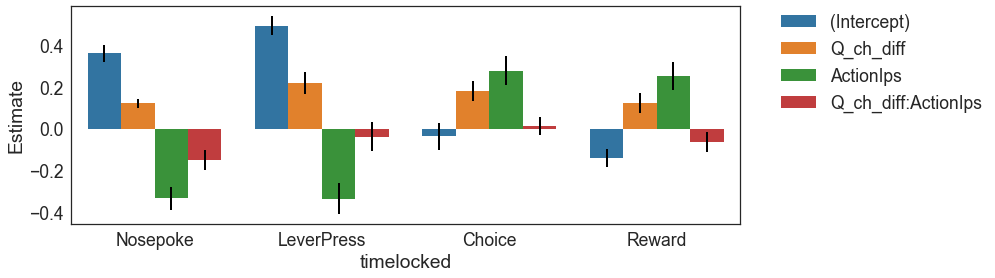

In [31]:
plt.figure(figsize = (12, 4))
ax = plt.gca()
sns.barplot(data = df, x = 'timelocked', y = 'Estimate', hue = 'names')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.errorbar(x=np.delete(np.arange(-0.3, 3.4, 0.2), [4, 9, 14]), y=df.Estimate, yerr=df['Std. Error'], fmt = 'None', elinewidth = 2, ecolor = 'k')


In [142]:
df

,Estimate,Std. Error,df,t value,Pr(>|t|),names,timelocked
1,0.361908,0.040722,10.970460,8.887253,2.416931e-06,(Intercept),Nosepoke
2,0.120731,0.022093,7.675619,5.464676,6.891859e-04,Q_ch_diff,Nosepoke
3,-0.335703,0.054791,10.826129,-6.127013,7.970730e-05,ActionIps,Nosepoke
4,-0.151535,0.048678,7.380306,-3.113025,1.590423e-02,Q_ch_diff:ActionIps,Nosepoke
5,0.494871,0.045104,11.063789,10.971726,2.756841e-07,(Intercept),LeverPress
6,0.217053,0.052906,10.164305,4.102646,2.063957e-03,Q_ch_diff,LeverPress
7,-0.337252,0.073554,10.260823,-4.585076,9.380945e-04,ActionIps,LeverPress
8,-0.039217,0.070203,11.217300,-0.558616,5.874019e-01,Q_ch_diff:ActionIps,LeverPress
9,-0.038282,0.063876,11.029213,-0.599320,5.610691e-01,(Intercept),Choice
10,0.179993,0.048125,10.245233,3.740130,3.687941e-03,Q_ch_diff,Choice


# First Pass Regression



**Regression to compute** 

avg_i ~  Q * Action + (1 + Q * Action |MouseID)

avg_i averages over 0 - 1.0 seconds with i = nosepoke, leverpresentation, choice, reward

Q = Q_chosen, Q_ch_diff, Q_dir_diff





In [12]:
df_corr_r = df_corr.drop(['g_np', 'g_lp', 'g_choice', 'g_reward', 'Stay/Leave'], axis = 1)
df_corr_r = df_corr_r.dropna()

In [14]:
%%R -i df_corr_r
print(head(df_corr_r))


  MouseID Trial Action Reward Session RecordLoc Reward_last        Q_c
1       0     1    Con      0       1       DMS           1 0.00000000
2       0     2    Con      0       1       DMS           0 0.63085854
3       0     3    Con      0       1       DMS           0 0.23127753
4       0     4    Con      0       1       DMS           0 0.08579952
5       0     5    Con      0       1       DMS           0 0.03219203
6       0     6    Ips      1       1       DMS           0 0.01220969
  Q_dir_diff   Q_chosen    Q_ch_diff     avg_np      avg_lp      avg_ch
1 0.00000000 0.63085854  0.630858539  0.0858689  0.59022748 -0.02674854
2 0.63085854 0.23127753  0.231277531  0.2290376 -0.12146094 -0.29159753
3 0.23127753 0.08579952  0.085799516  0.1095385  0.06057064 -0.69153950
4 0.08579952 0.03219203  0.032192034 -0.3119546 -0.36258663 -0.40678172
5 0.03219203 0.01220969  0.012209693 -0.3256196  0.08260307 -0.87649703
6 0.01220969 0.00000000 -0.004678988 -0.5410994  1.94120331  0.80696191

In [15]:
%%R -o nosepoke_m,leverprsnt_m

models = c("lmer(avg_np ~  Q_chosen * Action + (1 + Q_chosen * Action |MouseID), data = i)",
           "lmer(avg_np ~  Q_ch_diff * Action + (1 + Q_ch_diff * Action |MouseID), data = i)",
          "lmer(avg_np ~  Q_dir_diff * Action + (1 +  Q_dir_diff * Action|MouseID), data = i)")
np.list = f_lmer_mc(df_corr_r, models, 3)

nosepoke_m = np.list

models = c("lmer(avg_lp ~  Q_chosen * Action + (1 + Q_chosen * Action |MouseID), data = i)",
           "lmer(avg_lp ~  Q_ch_diff * Action + (1 + Q_ch_diff * Action |MouseID), data = i)",
          "lmer(avg_lp ~  Q_dir_diff * Action + (1 +  Q_dir_diff * Action|MouseID), data = i)")
lp.list = f_lmer_mc(df_corr_r, models, 3)

leverprsnt_m = lp.list


<IPython.core.display.Javascript object>

In [17]:
%%R -o choice_m

models = c("lmer(avg_ch ~  Q_chosen * Action + (1 + Q_chosen * Action |MouseID), data = i)",
           "lmer(avg_ch ~  Q_ch_diff * Action + (1 + Q_ch_diff * Action |MouseID), data = i)",
          "lmer(avg_ch ~  Q_dir_diff * Action + (1 +  Q_dir_diff * Action|MouseID), data = i)")
m.list = f_lmer_mc(df_corr_r, models, 3)

choice_m = m.list

models = c("lmer(avg_r ~  Q_chosen * Action + (1 + Q_chosen * Action |MouseID), data = i)",
           "lmer(avg_r ~  Q_ch_diff * Action + (1 + Q_ch_diff * Action |MouseID), data = i)",
          "lmer(avg_r ~  Q_dir_diff * Action + (1 +  Q_dir_diff * Action|MouseID), data = i)")
m.list = f_lmer_mc(df_corr_r, models, 3)

reward_m = m.list


<IPython.core.display.Javascript object>

In [18]:
import pickle 
mm = [nosepoke_m, leverprsnt_m, choice_m, reward_m]
pickle.dump(mm, open( "data/mm_reg.p", "wb" ) )

In [71]:
%R print(r.squaredGLMM(nosepoke_m[[1]]))
%R print(r.squaredGLMM(nosepoke_m[[2]]))
%R print(r.squaredGLMM(nosepoke_m[[3]]))


       R2m        R2c 
0.09558837 0.16984591 


       R2m        R2c 
0.09043357 0.16728096 


       R2m        R2c 
0.08412972 0.16107813 


In [117]:
%%R
Q_type = 2
df = as.data.frame(coef(summary(nosepoke_m[[Q_type]])))
df$names = rownames(df)
rownames(df) = NULL
df$timelocked = 'Nosepoke'




In [158]:
%R mm[1][[1]]


Error in withVisible({ : object 'mm' not found


/Users/sasha/anaconda/envs/biomath/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in withVisible({ : object 'mm' not found

  warnings.warn(x, RRuntimeWarning)


In [124]:
%%R -o
to_add <- c(leverprsnt_m[[Q_type]], choice_m[[Q_type]], reward_m[[Q_type]])
tl = c('LeverPress', 'Choice', 'Reward')
i = 0
for (mm_i in to_add){
    i = i + 1
    df_temp = as.data.frame(coef(summary(mm_i)))
    df_temp$names = rownames(df_temp)
    rownames(df_temp) = NULL
    df_temp$timelocked = tl[i]
    df = rbind(df, df_temp)
}



<IPython.core.display.Javascript object>

In [52]:
%R print(summary(reward_m[[1]]))

Linear mixed model fit by REML ['lmerMod']
Formula: avg_r ~ Q_chosen * Action + (1 + Q_chosen * Action | MouseID)
   Data: i

REML criterion at convergence: 19456.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.3818 -0.5998 -0.0753  0.4988  6.4283 

Random effects:
 Groups   Name               Variance Std.Dev. Corr             
 MouseID  (Intercept)        0.01375  0.1173                    
          Q_chosen           0.04896  0.2213   -0.05            
          ActionIps          0.04806  0.2192   -0.69  0.35      
          Q_chosen:ActionIps 0.05296  0.2301   -0.14 -0.88 -0.27
 Residual                    0.39976  0.6323                    
Number of obs: 10068, groups:  MouseID, 12

Fixed effects:
                   Estimate Std. Error t value
(Intercept)        -0.19690    0.03699  -5.323
Q_chosen            0.16193    0.06882   2.353
ActionIps           0.30158    0.06742   4.473
Q_chosen:ActionIps -0.10913    0.07611  -1.434

Correlation of Fixed Effects:
 

# Diagnostics Scripts

In [ ]:
%time %R print(summary(lmer('avg_lp ~  Q_chosen * Action + (1 + Q_chosen * Action |MouseID)', data=df_corr_r)))


In [ ]:
# test_data = sm.datasets.get_rdataset('dietox', 'geepack').data

# Simplest Regression 
formula = 'avg_lp ~  Q_chosen'
lm = ols(formula, data = df_corr).fit()
lm.summary()

formula = 'avg_lp ~  Q_chosen * Action' # with interaction



In [ ]:
plt.plot(lm.resid)

In [ ]:
from statsmodels.graphics.regressionplots import plot_leverage_resid2
fig, ax = plt.subplots(figsize=(8,6))
fig = plot_leverage_resid2(lm, ax = ax)

In [ ]:
influence = lm.get_influence()
#c is the distance and p is p-value
(c, p) = influence.cooks_distance
plt.stem(np.arange(len(c)), c, markerfmt=",")